In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import json
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

import xgboost as xgb
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# load data
data_path = Path("/Users/zhumiban/Desktop/agent_bank/src/data/processed/clean_fraud.csv")
df = pd.read_csv(data_path)

print(f"Data shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].mean():.4f}")

# feature engineering
df["transaction_datetime"] = pd.to_datetime(df["transaction_datetime"], errors="coerce")

df["trans_hour"] = df["transaction_datetime"].dt.hour
df["trans_dayofweek"] = df["transaction_datetime"].dt.dayofweek
df["trans_day"] = df["transaction_datetime"].dt.day
df["trans_month"] = df["transaction_datetime"].dt.month
df["is_night"] = df["trans_hour"].isin([0,1,2,3,4,5,6]).astype(int)

today = pd.Timestamp("today")
df["customer_dob"] = pd.to_datetime(df["customer_dob"], errors="coerce")
df["customer_age"] = ((today - df["customer_dob"]).dt.days / 365.25).astype("float32")

Data shape: (555719, 22)
Fraud rate: 0.0039


In [4]:
# define features
target_col = "is_fraud"

numeric_cols = [
    "transaction_amount",
    "customer_latitude",
    "customer_longitude",
    "customer_city_population",
    "transaction_unix_time",
    "merchant_latitude",
    "merchant_longitude",
]

derived_numeric_cols = [
    "trans_hour", "trans_dayofweek", "trans_day",
    "trans_month", "is_night", "customer_age"
]

categorical_cols = [
    "merchant_name",
    "merchant_category",
    "customer_first_name",
    "customer_last_name",
    "customer_gender",
    "customer_city",
    "customer_state",
    "customer_job_title",
]

numeric_cols = [c for c in numeric_cols if c in df.columns]
derived_numeric_cols = [c for c in derived_numeric_cols if c in df.columns]
categorical_cols = [c for c in categorical_cols if c in df.columns]

feature_cols = numeric_cols + derived_numeric_cols + categorical_cols

print(f"numeric_cols: {len(numeric_cols)}")
print(f"derived_numeric_cols: {len(derived_numeric_cols)}")
print(f"categorical_cols: {len(categorical_cols)}")
print(f"feature_cols: {len(feature_cols)}")

# split by customer to avoid leakage
unique_customers = df["customer_id_number"].unique()
print(f"Total unique customers: {len(unique_customers)}")

train_customers, temp_customers = train_test_split(
    unique_customers,
    test_size=0.3,
    random_state=RANDOM_STATE,
    shuffle=True
)

val_customers, test_customers = train_test_split(
    temp_customers,
    test_size=1/3,
    random_state=RANDOM_STATE,
    shuffle=True
)

train_df = df[df["customer_id_number"].isin(train_customers)].copy()
val_df   = df[df["customer_id_number"].isin(val_customers)].copy()
test_df  = df[df["customer_id_number"].isin(test_customers)].copy()

print(f"\nTrain set: {len(train_df)} samples ({len(train_customers)} customers)")
print(f"Validation set: {len(val_df)} samples ({len(val_customers)} customers)")
print(f"Test set: {len(test_df)} samples ({len(test_customers)} customers)")

# Sanity check: no overlap
assert len(set(train_customers) & set(val_customers)) == 0
assert len(set(train_customers) & set(test_customers)) == 0
assert len(set(val_customers) & set(test_customers)) == 0
print("\n Data splitting verified: No customer overlap between sets")


numeric_cols: 7
derived_numeric_cols: 6
categorical_cols: 8
feature_cols: 21
Total unique customers: 904

Train set: 380687 samples (632 customers)
Validation set: 117851 samples (181 customers)
Test set: 57181 samples (91 customers)

 Data splitting verified: No customer overlap between sets


In [ ]:
# categorical encoding & missing values
categorical_categories = {}
numeric_medians = {}
for col in categorical_cols:
    # fill missing values & convert to string
    train_df[col] = train_df[col].fillna("Missing").astype(str)
    val_df[col]   = val_df[col].fillna("Missing").astype(str)
    test_df[col]  = test_df[col].fillna("Missing").astype(str)

    # fit categories on training set
    train_df[col] = train_df[col].astype("category")
    categorical_categories[col] = list(train_df[col].cat.categories)

    # validation & test use same categories, unseen categories will be NaN
    val_df[col]  = pd.Categorical(val_df[col],  categories=train_df[col].cat.categories)
    test_df[col] = pd.Categorical(test_df[col], categories=train_df[col].cat.categories)

    # convert to int
    train_df[col] = train_df[col].cat.codes
    val_df[col]   = val_df[col].cat.codes
    test_df[col]  = test_df[col].cat.codes

# numeric features missing values filled with median of training set
for col in numeric_cols + derived_numeric_cols:
    if col in train_df.columns:
        median_val = train_df[col].median()
        numeric_medians[col] = float(median_val)

        train_df[col] = train_df[col].fillna(median_val)
        val_df[col]   = val_df[col].fillna(median_val)
        test_df[col]  = test_df[col].fillna(median_val)

print("Feature preprocessing completed")


Feature preprocessing completed


In [6]:
# prepare matrices
X_train = train_df[feature_cols]
y_train = train_df[target_col].astype(int)

X_val = val_df[feature_cols]
y_val = val_df[target_col].astype(int)

X_test = test_df[feature_cols]
y_test = test_df[target_col].astype(int)

print(f"Train: {X_train.shape}, Fraud rate: {y_train.mean():.4f}")
print(f"Validation: {X_val.shape}, Fraud rate: {y_val.mean():.4f}")
print(f"Test: {X_test.shape}, Fraud rate: {y_test.mean():.4f}")

# Imbalanced data weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"\nScale pos weight: {scale_pos_weight:.2f}")


Train: (380687, 21), Fraud rate: 0.0039
Validation: (117851, 21), Fraud rate: 0.0040
Test: (57181, 21), Fraud rate: 0.0036

Scale pos weight: 258.32


In [ ]:
# model training
clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    gamma=0.0,
    scale_pos_weight=scale_pos_weight,

    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=1,
    early_stopping_rounds=50,
)

print("Training XGBoost model...")
clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

print("\n Model training completed")


Training XGBoost model...
[0]	validation_0-auc:0.96575
[50]	validation_0-auc:0.98789
[100]	validation_0-auc:0.99032
[150]	validation_0-auc:0.99165
[200]	validation_0-auc:0.99134
[214]	validation_0-auc:0.99150

 Model training completed


In [ ]:
# Validation
y_val_proba = clf.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

val_auc = roc_auc_score(y_val, y_val_proba)
print(f"Validation AUC: {val_auc:.4f}\n")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Test
y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nTest AUC: {test_auc:.4f}\n")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)


In [17]:
from sklearn.metrics import precision_score, recall_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

print("===== Validation set threshold sweep (for fraud class, label=1) =====")
for thr in thresholds:
    y_val_pred_thr = (y_val_proba >= thr).astype(int)
    p = precision_score(y_val, y_val_pred_thr, pos_label=1, zero_division=0)
    r = recall_score(y_val, y_val_pred_thr, pos_label=1, zero_division=0)
    print(f"Threshold {thr:4.2f} -> precision: {p:6.3f}, recall: {r:6.3f}")

print("\n===== Test set threshold sweep (for fraud class, label=1) =====")
for thr in thresholds:
    y_test_pred_thr = (y_test_proba >= thr).astype(int)
    p = precision_score(y_test, y_test_pred_thr, pos_label=1, zero_division=0)
    r = recall_score(y_test, y_test_pred_thr, pos_label=1, zero_division=0)
    print(f"Threshold {thr:4.2f} -> precision: {p:6.3f}, recall: {r:6.3f}")



===== Validation set threshold sweep (for fraud class, label=1) =====
Threshold 0.10 -> precision:  0.070, recall:  0.979
Threshold 0.20 -> precision:  0.123, recall:  0.941
Threshold 0.30 -> precision:  0.178, recall:  0.924
Threshold 0.40 -> precision:  0.226, recall:  0.904
Threshold 0.50 -> precision:  0.281, recall:  0.892
Threshold 0.60 -> precision:  0.341, recall:  0.862
Threshold 0.70 -> precision:  0.416, recall:  0.832
Threshold 0.80 -> precision:  0.517, recall:  0.790
Threshold 0.90 -> precision:  0.675, recall:  0.724
Threshold 0.95 -> precision:  0.853, recall:  0.626

===== Test set threshold sweep (for fraud class, label=1) =====
Threshold 0.10 -> precision:  0.062, recall:  0.971
Threshold 0.20 -> precision:  0.108, recall:  0.927
Threshold 0.30 -> precision:  0.154, recall:  0.913
Threshold 0.40 -> precision:  0.200, recall:  0.908
Threshold 0.50 -> precision:  0.249, recall:  0.893
Threshold 0.60 -> precision:  0.300, recall:  0.864
Threshold 0.70 -> precision:  0.3

In [18]:
data_split_dir = Path("/Users/zhumiban/Desktop/agent_bank/src/data/processed_splits")
data_split_dir.mkdir(parents=True, exist_ok=True)

id_cols = []
for col in ["customer_id_number", "transaction_id"]:
    if col in train_df.columns:
        id_cols.append(col)

cols_to_save = id_cols + feature_cols + [target_col]

train_save_path = data_split_dir / "train_processed.csv"
val_save_path   = data_split_dir / "val_processed.csv"
test_save_path  = data_split_dir / "test_processed.csv"

train_df[cols_to_save].to_csv(train_save_path, index=False)
val_df[cols_to_save].to_csv(val_save_path, index=False)
test_df[cols_to_save].to_csv(test_save_path, index=False)

print("Saved processed datasets:")
print(f"  - Train: {train_save_path}")
print(f"  - Val:   {val_save_path}")
print(f"  - Test:  {test_save_path}")


Saved processed datasets:
  - Train: /Users/zhumiban/Desktop/agent_bank/src/data/processed_splits/train_processed.csv
  - Val:   /Users/zhumiban/Desktop/agent_bank/src/data/processed_splits/val_processed.csv
  - Test:  /Users/zhumiban/Desktop/agent_bank/src/data/processed_splits/test_processed.csv


for the current stage, we would take 0.6 as our best threshold

In [ ]:
# save model & metadata
model_dir = Path("/Users/zhumiban/Desktop/agent_bank/src/data/model")
model_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = model_dir / "fraud_detection_model.pkl"
joblib.dump(clf, model_path)
print(f"✅ Model saved to: {model_path}")

# save categorical mapping (for deployment)
categories_path = model_dir / "categorical_categories.pkl"
joblib.dump(categorical_categories, categories_path)
print(f"✅ Categorical categories saved to: {categories_path}")

feature_info = {
    "feature_cols": feature_cols,
    "numeric_cols": numeric_cols,
    "derived_numeric_cols": derived_numeric_cols,
    "categorical_cols": categorical_cols,
    "target_col": target_col,
    "scale_pos_weight": float(scale_pos_weight),
    "train_size": len(train_df),
    "val_size": len(val_df),
    "test_size": len(test_df),
    "train_fraud_rate": float(y_train.mean()),
    "val_fraud_rate": float(y_val.mean()),
    "test_fraud_rate": float(y_test.mean()),
    "val_auc": float(val_auc),
    "test_auc": float(test_auc),
    "training_date": datetime.now().isoformat(),
    "random_state": RANDOM_STATE,
}

feature_info_path = model_dir / "model_info.json"
with open(feature_info_path, "w") as f:
    json.dump(feature_info, f, indent=2)
print(f"✅ Model info saved to: {feature_info_path}")

print("\n✅ All files saved successfully!")


✅ Model saved to: /Users/zhumiban/Desktop/agent_bank/src/data/model/fraud_detection_model.pkl
✅ Categorical categories saved to: /Users/zhumiban/Desktop/agent_bank/src/data/model/categorical_categories.pkl
✅ Model info saved to: /Users/zhumiban/Desktop/agent_bank/src/data/model/model_info.json

✅ All files saved successfully!


In [21]:
numeric_medians_path = model_dir / "numeric_medians.pkl"
joblib.dump(numeric_medians, numeric_medians_path)
print(f" Numeric medians saved to: {numeric_medians_path}")

 Numeric medians saved to: /Users/zhumiban/Desktop/agent_bank/src/data/model/numeric_medians.pkl


<Figure size 1000x800 with 0 Axes>

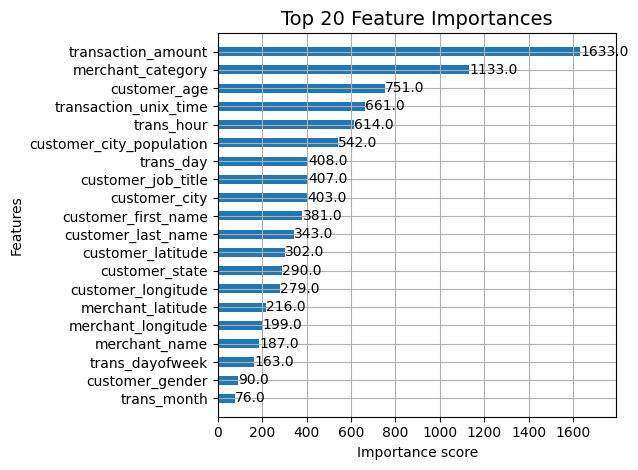

✅ Feature importance plot saved


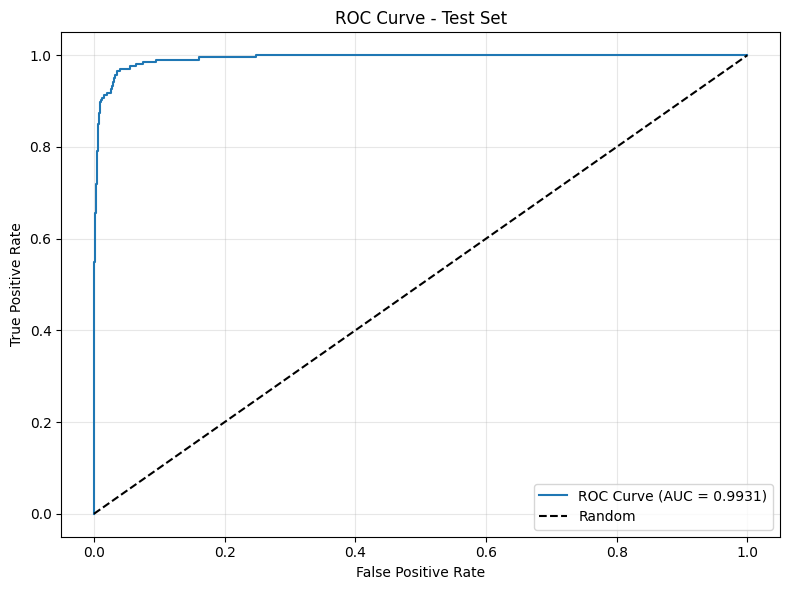

✅ ROC curve plot saved


In [ ]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(clf, max_num_features=20, height=0.5)
plt.title("Top 20 Feature Importances", fontsize=14)
plt.tight_layout()
plt.savefig(model_dir / "feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Feature importance plot saved")

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(model_dir / "roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ ROC curve plot saved")
